In [1]:
# ---------------------------------------
# CUDA & Device Configuration
# ---------------------------------------
import torch
print("CUDA Available:", torch.cuda.is_available())  # Check if CUDA is available
print("GPU Count:", torch.cuda.device_count())       # Number of available GPUs
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")  # Get GPU name

CUDA Available: True
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
# ---------------------------------------
# Imports & Dependencies
# ---------------------------------------
import json 
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import  classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve,auc, roc_auc_score, auc
from tqdm import tqdm
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ---------------------------------------
# 0. Setup Device
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Automatically choose GPU if available
print(f"Using device: {device}")

Using device: cuda


In [4]:
# ---------------------------------------
# 1. Dataset Path Configuration
# ---------------------------------------
dataset_path = r"E:/Dataset 2"
file_names = ["train_revised.json", "dev_revised.json", "test_revised.json"]

In [5]:
# ---------------------------------------
# 2. Load JSON Datasets
# ---------------------------------------
datasets = {}
for file_name in file_names:
    with open(os.path.join(dataset_path, file_name), 'r', encoding='utf-8') as f:
        datasets[file_name] = json.load(f)  # Load each JSON file into a Python dictionary

In [6]:
# ---------------------------------------
# 3. Load Tokenizer
# ---------------------------------------
tokenizer = AutoTokenizer.from_pretrained("roberta-base")  # Pre-trained RoBERTa tokenizer from HuggingFace

In [7]:
# ---------------------------------------
# 4. Custom Dataset with Curriculum Learning
# ---------------------------------------
class DocRED_Dataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512, max_entities=64):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.max_entities = max_entities
        self.samples = self._process()  # Preprocess and tokenize data
        self.samples.sort(key=lambda x: x["difficulty"])  # Sort samples by difficulty for curriculum learning

    def _process(self):
        samples = []
        for item in self.data:
            flat_text = " ".join([" ".join(sent) for sent in item["sents"]])  # Flatten nested sentence structure
            inputs = self.tokenizer(
                flat_text,
                truncation=True,
                padding="max_length",
                max_length=self.max_length,
                return_tensors="pt"
            )

            # Create binary label tensor for entity relations
            label_tensor = torch.zeros((self.max_entities, self.max_entities))
            for rel in item.get("labels", []):
                h_idx, t_idx = rel["h"], rel["t"]
                if h_idx < self.max_entities and t_idx < self.max_entities:
                    label_tensor[h_idx][t_idx] = 1

            # Difficulty based on number of entities (used for curriculum learning)
            entity_count = min(len(item["vertexSet"]), self.max_entities)
            difficulty = entity_count * entity_count

            samples.append({
                "input_ids": inputs["input_ids"].squeeze(0),
                "attention_mask": inputs["attention_mask"].squeeze(0),
                "labels": label_tensor,
                "difficulty": difficulty
            })
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return {
            "input_ids": sample["input_ids"],
            "attention_mask": sample["attention_mask"],
            "labels": sample["labels"]
        }

    def get_curriculum_subset(self, percent=1.0):
        size = int(len(self.samples) * percent)
        return Subset(self, list(range(size)))  # Return a subset of the dataset for curriculum learning

In [8]:
# ---------------------------------------
# 5. Relation Extraction Model (RoBERTa-based)
# ---------------------------------------
class DocREModel(nn.Module):
    def __init__(self, model_name="roberta-base", hidden_size=768, max_entities=64):
        super(DocREModel, self).__init__()
        self.max_entities = max_entities
        self.encoder = AutoModel.from_pretrained(model_name)  # Load pre-trained RoBERTa encoder
        self.classifier = nn.Linear(hidden_size, max_entities * max_entities)  # Classifier to predict relation matrix

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token representation
        logits = self.classifier(cls_output)
        return logits.view(-1, self.max_entities, self.max_entities)  # Reshape to relation matrix

In [9]:
# ---------------------------------------
# 6. Compute Positive Class Weight
# ---------------------------------------
def compute_pos_weight(dataloader):
    total_pos = 0
    total_neg = 0
    for batch in dataloader:
        labels = batch['labels']
        total_pos += labels.sum().item()
        total_neg += labels.numel() - labels.sum().item()
    return torch.tensor(total_neg / (total_pos + 1e-6)).to(device)  # Avoid division by zero

In [10]:
# ---------------------------------------
# 7. Training Function with Adaptive Thresholding
# ---------------------------------------
def train(model, dataloader, optimizer, loss_fn, threshold=0.5):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        probs = torch.sigmoid(logits).detach().cpu().numpy()  # Apply sigmoid to get probabilities
        preds = (probs > threshold).astype(int)               # Binarize predictions using threshold
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

    acc = accuracy_score(all_labels, all_preds)
    print(classification_report(all_labels, all_preds, digits=4))
    return total_loss / len(dataloader), acc  # Return average loss and accuracy

In [11]:
# ---------------------------------------
# 8. Evaluation Function
# ---------------------------------------
def evaluate(model, dataloader, loss_fn, threshold=0.5, title="Eval"):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=title):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > threshold).astype(int)
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(dataloader), acc, all_labels, all_preds

In [12]:
# ---------------------------------------
# 9. Prepare Datasets & Dataloaders
# ---------------------------------------
max_entities = 64
train_dataset = DocRED_Dataset(datasets["train_revised.json"], tokenizer, max_entities=max_entities)
dev_dataset = DocRED_Dataset(datasets["dev_revised.json"], tokenizer, max_entities=max_entities)
test_dataset = DocRED_Dataset(datasets["test_revised.json"], tokenizer, max_entities=max_entities)

dev_loader = DataLoader(dev_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [13]:
# ---------------------------------------
# 10. Initialize Model, Loss Function, Optimizer
# ---------------------------------------
model = DocREModel(model_name="roberta-base", hidden_size=768, max_entities=64).to(device)
pos_weight = compute_pos_weight(DataLoader(train_dataset, batch_size=16))
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Handle class imbalance
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# ---------------------------------------
# 11. Training Loop with Curriculum Learning & Adaptive Threshold
# ---------------------------------------
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
patience = 3
patience_counter = 0

adaptive_threshold = 0.7
threshold_step = 0.01
min_threshold = 0.65
max_threshold = 0.85

overall_start_time = time.time()
EPOCHS = 5
curriculum_schedule = np.linspace(0.2, 1.0, EPOCHS)  # Gradual increase in difficulty

for epoch in range(EPOCHS):
    print(f"\n Epoch {epoch+1}")
    epoch_start_time = time.time()

    percent = curriculum_schedule[epoch]
    print(f" Curriculum: using top {percent:.2f} easiest samples")
    train_subset = train_dataset.get_curriculum_subset(percent)
    train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)

    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, threshold=adaptive_threshold)
    val_loss, val_acc, val_labels, val_preds = evaluate(model, dev_loader, loss_fn, threshold=adaptive_threshold, title="Validation")

    print(f" Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f" Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print("\n Validation Classification Report")
    print(classification_report(val_labels, val_preds, digits=4))

    auc_val = roc_auc_score(val_labels, val_preds)
    print(f" AUC Score: {auc_val:.4f}")

    # Update threshold based on validation AUC
    if auc_val < 0.9:
        adaptive_threshold = max(min_threshold, adaptive_threshold - threshold_step)
    else:
        adaptive_threshold = min(max_threshold, adaptive_threshold + threshold_step)
    print(f" Adaptive Threshold: {adaptive_threshold:.4f}")

    epoch_end_time = time.time()
    print(f" Epoch Time: {(epoch_end_time - epoch_start_time) / 60:.2f} minutes")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        print(f" Early stopping patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(" Early stopping triggered.")
            break
            
overall_end_time = time.time()


 Epoch 1
 Curriculum: using top 0.20 easiest samples


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:25<00:00,  3.06it/s]


              precision    recall  f1-score   support

         0.0     0.9993    0.9781    0.9886   2489974
         1.0     0.1107    0.7905    0.1943      8586

    accuracy                         0.9775   2498560
   macro avg     0.5550    0.8843    0.5914   2498560
weighted avg     0.9962    0.9775    0.9858   2498560



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.91it/s]


 Train Loss: 0.4458, Accuracy: 0.9775
 Val   Loss: 1.3722, Accuracy: 0.9678

 Validation Classification Report
              precision    recall  f1-score   support

         0.0     0.9977    0.9699    0.9836   2034638
         1.0     0.1246    0.6524    0.2092     13362

    accuracy                         0.9678   2048000
   macro avg     0.5611    0.8112    0.5964   2048000
weighted avg     0.9920    0.9678    0.9785   2048000

 AUC Score: 0.8112
 Adaptive Threshold: 0.6900
 Epoch Time: 0.64 minutes

 Epoch 2
 Curriculum: using top 0.40 easiest samples


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:50<00:00,  3.04it/s]


              precision    recall  f1-score   support

         0.0     0.9997    0.9617    0.9803   4981096
         1.0     0.0886    0.9212    0.1616     20120

    accuracy                         0.9615   5001216
   macro avg     0.5441    0.9415    0.5710   5001216
weighted avg     0.9960    0.9615    0.9770   5001216



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.27it/s]


 Train Loss: 0.2467, Accuracy: 0.9615
 Val   Loss: 1.3463, Accuracy: 0.9546

 Validation Classification Report
              precision    recall  f1-score   support

         0.0     0.9984    0.9559    0.9767   2034638
         1.0     0.1017    0.7597    0.1794     13362

    accuracy                         0.9546   2048000
   macro avg     0.5500    0.8578    0.5780   2048000
weighted avg     0.9925    0.9546    0.9715   2048000

 AUC Score: 0.8578
 Adaptive Threshold: 0.6800
 Epoch Time: 1.14 minutes

 Epoch 3
 Curriculum: using top 0.60 easiest samples


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [01:14<00:00,  3.06it/s]


              precision    recall  f1-score   support

         0.0     0.9997    0.9465    0.9724   7465922
         1.0     0.0740    0.9428    0.1372     33854

    accuracy                         0.9465   7499776
   macro avg     0.5369    0.9446    0.5548   7499776
weighted avg     0.9955    0.9465    0.9686   7499776



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.26it/s]


 Train Loss: 0.2660, Accuracy: 0.9465
 Val   Loss: 0.9937, Accuracy: 0.9412

 Validation Classification Report
              precision    recall  f1-score   support

         0.0     0.9989    0.9419    0.9696   2034638
         1.0     0.0869    0.8427    0.1576     13362

    accuracy                         0.9412   2048000
   macro avg     0.5429    0.8923    0.5636   2048000
weighted avg     0.9930    0.9412    0.9643   2048000

 AUC Score: 0.8923
 Adaptive Threshold: 0.6700
 Epoch Time: 1.63 minutes

 Epoch 4
 Curriculum: using top 0.80 easiest samples


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [01:40<00:00,  3.05it/s]


              precision    recall  f1-score   support

         0.0     0.9997    0.9310    0.9641   9953262
         1.0     0.0631    0.9408    0.1183     49170

    accuracy                         0.9311  10002432
   macro avg     0.5314    0.9359    0.5412  10002432
weighted avg     0.9951    0.9311    0.9600  10002432



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.06it/s]


 Train Loss: 0.3150, Accuracy: 0.9311
 Val   Loss: 0.6686, Accuracy: 0.9296

 Validation Classification Report
              precision    recall  f1-score   support

         0.0     0.9992    0.9299    0.9633   2034638
         1.0     0.0768    0.8879    0.1414     13362

    accuracy                         0.9296   2048000
   macro avg     0.5380    0.9089    0.5523   2048000
weighted avg     0.9932    0.9296    0.9579   2048000

 AUC Score: 0.9089
 Adaptive Threshold: 0.6800
 Epoch Time: 2.23 minutes

 Epoch 5
 Curriculum: using top 1.00 easiest samples


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [02:18<00:00,  2.75it/s]


              precision    recall  f1-score   support

         0.0     0.9995    0.9163    0.9561  12437280
         1.0     0.0562    0.9138    0.1059     67808

    accuracy                         0.9163  12505088
   macro avg     0.5278    0.9151    0.5310  12505088
weighted avg     0.9944    0.9163    0.9515  12505088



Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.20it/s]


 Train Loss: 0.4114, Accuracy: 0.9163
 Val   Loss: 0.4361, Accuracy: 0.9155

 Validation Classification Report
              precision    recall  f1-score   support

         0.0     0.9995    0.9154    0.9556   2034638
         1.0     0.0671    0.9260    0.1251     13362

    accuracy                         0.9155   2048000
   macro avg     0.5333    0.9207    0.5403   2048000
weighted avg     0.9934    0.9155    0.9502   2048000

 AUC Score: 0.9207
 Adaptive Threshold: 0.6900
 Epoch Time: 2.84 minutes


In [15]:
# ---------------------------------------
#  Total Training Time
# ---------------------------------------
total_training_time = (overall_end_time - overall_start_time) / 60
print(f"\n Total Training Time: {total_training_time:.2f} minutes")


 Total Training Time: 8.47 minutes


In [16]:
# ---------------------------------------
#  Load Best Model & Final Dev Evaluation
# ---------------------------------------
model.load_state_dict(best_model_state)
val_loss, val_acc, val_labels, val_preds = evaluate(model, dev_loader, loss_fn, title="Final Validation")
final_auc = roc_auc_score(val_labels, val_preds)
print(f" Final Adaptive Threshold: {adaptive_threshold:.4f}")
print(f" Final Validation AUC (Best Model): {final_auc:.4f}")

Final Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.30it/s]


 Final Adaptive Threshold: 0.6900
 Final Validation AUC (Best Model): 0.9257


In [17]:
# ---------------------------------------
#  Final Test Set Evaluation
# ---------------------------------------
test_loss, test_acc, test_labels, test_preds = evaluate(model, test_loader, loss_fn, title="Test")
print(f"\n Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print("\n Final Test Classification Report")
print(classification_report(test_labels, test_preds, digits=4))

Test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.38it/s]



 Test Loss: 0.5090, Accuracy: 0.8817

 Final Test Classification Report
              precision    recall  f1-score   support

         0.0     0.9997    0.8811    0.9367   2034373
         1.0     0.0516    0.9651    0.0979     13627

    accuracy                         0.8817   2048000
   macro avg     0.5257    0.9231    0.5173   2048000
weighted avg     0.9934    0.8817    0.9311   2048000



In [18]:
# ---------------------------------------
#  Final Test Metrics (Percent Format)
# ---------------------------------------

# Compute evaluation metrics on test predictions
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

# Display results in percentage format with 2 decimal places
print(f"\n Final Test Metrics (Percentage Format):")
print(f" Accuracy : {test_accuracy * 100:.2f}%")    
print(f" Precision: {test_precision * 100:.2f}%")    
print(f" Recall   : {test_recall * 100:.2f}%")       
print(f" F1 Score : {test_f1 * 100:.2f}%")            


 Final Test Metrics (Percentage Format):
 Accuracy : 88.17%
 Precision: 5.16%
 Recall   : 96.51%
 F1 Score : 9.79%


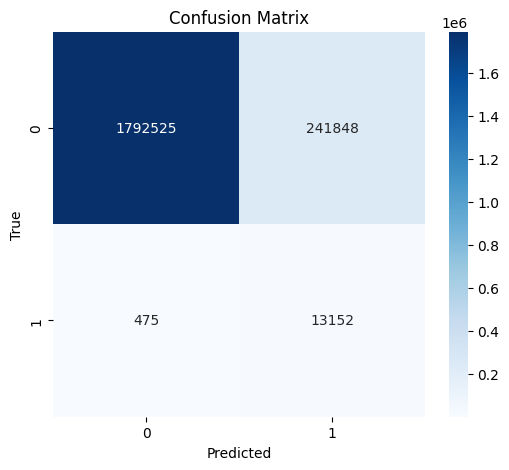

In [19]:
# ---------------------------------------
#  Confusion Matrix
# ---------------------------------------
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('E:/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

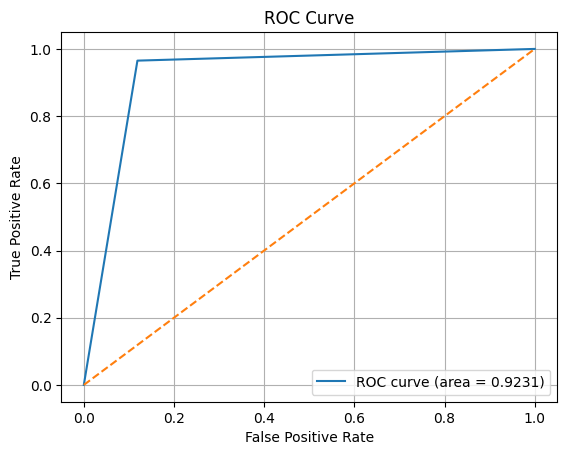

In [20]:
# ---------------------------------------
#  ROC Curve
# ---------------------------------------
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('E:/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()